In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Loading the preprocessed datasets
X_train_full = np.load("/content/drive/MyDrive/ML/Preprocessed_Data/X_train_scaled.npy")
y_train_full = np.load("/content/drive/MyDrive/ML/Preprocessed_Data/y_train.npy")
X_test = np.load("/content/drive/MyDrive/ML/Preprocessed_Data/X_test_scaled.npy")
y_test = np.load("/content/drive/MyDrive/ML/Preprocessed_Data/y_test.npy")

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Printing out the data shapes for verification
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (45031, 1092), (45031, 2)
Validation set: (11258, 1092), (11258, 2)
Test set: (39804, 1092), (39804, 2)


MODEL DEFINITION


In [ ]:

def create_neural_network(input_dim):
          model = tf.keras.Sequential([
          tf.keras.layers.Input(shape=(X_train_full.shape[1],)),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(2)  # Two outputs: v and w
    ])
          model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
          return model

HYPER-PARAMETER TUNING (Takes 45-50 min of runtime)



In [ ]:

# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_val, y_val, batch_size, learning_rate, epochs=50):
    """
    Trains the model with the given batch size and learning rate, and returns the validation loss.
    """
    # Creating the model with the given architecture
    model = create_neural_network(input_dim=X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Training the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stopping]
    )

    # Returning the final validation loss
    val_loss = history.history['val_loss'][-1]
    return val_loss

# The Hyperparameter grid
batch_sizes = [16, 32, 64]  # Batch sizes to try
learning_rates = [0.001, 0.01, 0.0005]  # Learning rates to try
epochs = 50  # Fixed number of epochs for both cases

# Storing the best parameter results
results = []
best_params = {}
best_loss = float('inf')

# Grid searching over the batch size and learning rate
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        print(f"Training with Batch Size: {batch_size}, Learning Rate: {learning_rate}")

        # Training and evaluating the final model
        val_loss = train_and_evaluate_model(X_train, y_train, X_val, y_val, batch_size, learning_rate, epochs)
        print(f"Validation Loss: {val_loss:.4f}")

        # Storing the results
        results.append({'batch_size': batch_size, 'learning_rate': learning_rate, 'val_loss': val_loss})

        # Updating the best parameters
        if val_loss < best_loss:
            best_loss = val_loss
            best_params = {'batch_size': batch_size, 'learning_rate': learning_rate}

# Printing out the best hyperparameters
print("\nBest Hyperparameters:")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Best Validation Loss: {best_loss:.4f}")

Training with Batch Size: 16, Learning Rate: 0.001
Validation Loss: 0.0278
Training with Batch Size: 16, Learning Rate: 0.01
Validation Loss: 0.1089
Training with Batch Size: 16, Learning Rate: 0.0005
Validation Loss: 0.0192
Training with Batch Size: 32, Learning Rate: 0.001
Validation Loss: 0.0225
Training with Batch Size: 32, Learning Rate: 0.01
Validation Loss: 0.0999
Training with Batch Size: 32, Learning Rate: 0.0005
Validation Loss: 0.0218
Training with Batch Size: 64, Learning Rate: 0.001
Validation Loss: 0.0185
Training with Batch Size: 64, Learning Rate: 0.01
Validation Loss: 0.1079
Training with Batch Size: 64, Learning Rate: 0.0005
Validation Loss: 0.0197

Best Hyperparameters:
Batch Size: 64
Learning Rate: 0.001
Best Validation Loss: 0.0185


In [ ]:
# Combining training and validation data for the final training
X_train_combined = np.vstack((X_train, X_val))
y_train_combined = np.vstack((y_train, y_val))

# Training the final model with the best hyperparameters
final_model = create_neural_network(input_dim=X_train_combined.shape[1])
history = final_model.fit(X_train_combined, y_train_combined, validation_data=(X_val, y_val), epochs=50, batch_size=64, verbose=2)

# Evaluate on the test data
y_pred = final_model.predict(X_test)
mse_test = tf.keras.losses.MeanSquaredError()(y_test, y_pred).numpy()
print(f"Test Mean Squared Error (MSE): {mse_test}")

Epoch 1/50
880/880 - 6s - 6ms/step - loss: 0.0780 - mae: 0.1998 - val_loss: 0.0628 - val_mae: 0.1757
Epoch 2/50
880/880 - 5s - 5ms/step - loss: 0.0557 - mae: 0.1632 - val_loss: 0.0492 - val_mae: 0.1502
Epoch 3/50
880/880 - 6s - 7ms/step - loss: 0.0484 - mae: 0.1498 - val_loss: 0.0453 - val_mae: 0.1466
Epoch 4/50
880/880 - 4s - 4ms/step - loss: 0.0433 - mae: 0.1404 - val_loss: 0.0424 - val_mae: 0.1398
Epoch 5/50
880/880 - 5s - 6ms/step - loss: 0.0395 - mae: 0.1332 - val_loss: 0.0372 - val_mae: 0.1308
Epoch 6/50
880/880 - 7s - 8ms/step - loss: 0.0366 - mae: 0.1283 - val_loss: 0.0361 - val_mae: 0.1278
Epoch 7/50
880/880 - 4s - 4ms/step - loss: 0.0337 - mae: 0.1221 - val_loss: 0.0310 - val_mae: 0.1165
Epoch 8/50
880/880 - 4s - 4ms/step - loss: 0.0313 - mae: 0.1177 - val_loss: 0.0285 - val_mae: 0.1099
Epoch 9/50
880/880 - 7s - 8ms/step - loss: 0.0300 - mae: 0.1153 - val_loss: 0.0287 - val_mae: 0.1118
Epoch 10/50
880/880 - 4s - 4ms/step - loss: 0.0278 - mae: 0.1109 - val_loss: 0.0282 - val_m

In [ ]:

# Function to calculate VC bound
def calculate_vc_bound(E_in, N, vc_dim, delta=0.05):
    if vc_dim >= 2 * N:
        print("Warning: VC dimension is too large compared to dataset size. Adjusting VC dimension.")
        vc_dim = vc_dim
    confidence_term = np.sqrt((vc_dim * np.log(2 * N / vc_dim) + np.log(4 / delta)) / N)
    return E_in + confidence_term

# Calculating the in-sample error (E_in)
E_in = val_loss  # Training loss after the final training (tuned hyperparameters)

# Estimating the VC dimension (number of trainable parameters) (Only considering the first 20 relevant features and their weights)
vc_dim = 400

# Calculating the VC bound
N = X_train_combined.shape[0]  # Number of training samples
vc_bound = calculate_vc_bound(E_in, N, vc_dim)
print(vc_dim)
print(N)
print(val_loss)
print(f"In-Sample Error (E_in): {E_in}")
print(f"VC Generalization Bound (E_out): {vc_bound}")
print(f"Test Loss (E_test): {mse_test}")

400
56289
0.019737165421247482
In-Sample Error (E_in): 0.019
VC Generalization Bound (E_out): 0.2193903191433006
Test Loss (E_test): 0.14580602943897247


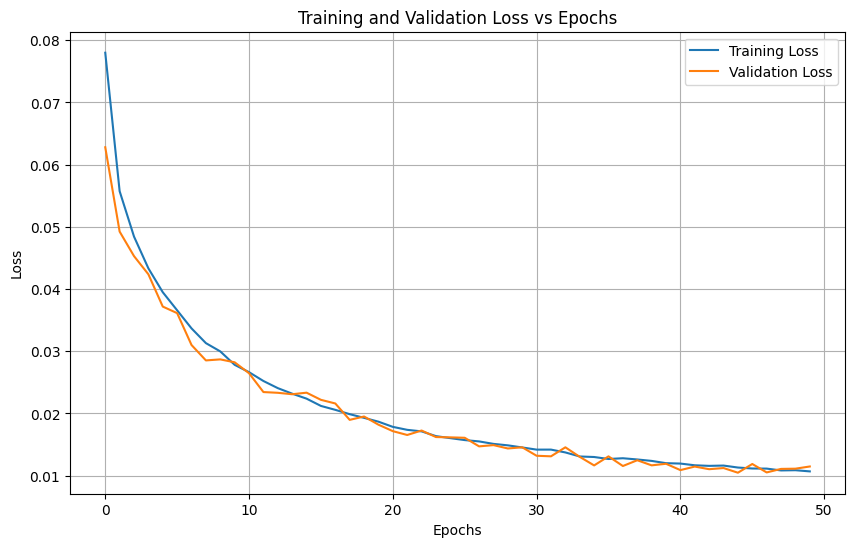

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss vs Epochs')
plt.grid()
plt.show()

Very computationally expensive (takes about 25-30 mins to execute)

Training with dataset size: 5628
Training with dataset size: 11257
Training with dataset size: 22515
Training with dataset size: 33773
Training with dataset size: 45031
Training with dataset size: 56289


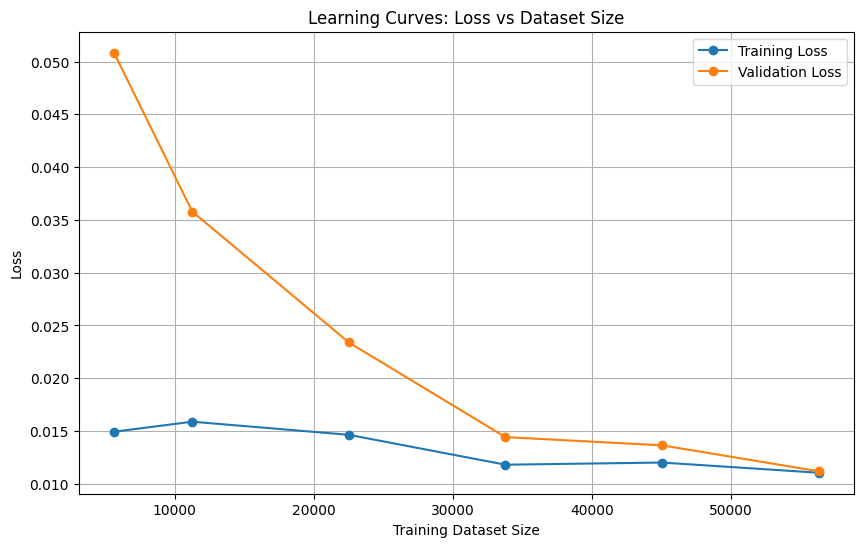

In [ ]:


# Varying the dataset sizes in fractional ratios
dataset_sizes = [int(len(X_train_full) * ratio) for ratio in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]]
train_losses = []
val_losses = []

for size in dataset_sizes:
    print(f"Training with dataset size: {size}")
    # Sampling the training dataset
    X_train_subset = X_train_full[:size]
    y_train_subset = y_train_full[:size]

    # Creating and train the model on the subset (varying)
    model = create_neural_network(X_train_full.shape[1])
    history = model.fit(
        X_train_subset, y_train_subset,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0  # Suppressing detailed logs
    )

    # Recording all the training and validation losses
    train_losses.append(history.history['loss'][-1])
    val_losses.append(history.history['val_loss'][-1])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, train_losses, label='Training Loss', marker='o')
plt.plot(dataset_sizes, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Training Dataset Size')
plt.ylabel('Loss')
plt.title('Learning Curves: Loss vs Dataset Size')
plt.legend()
plt.grid()
plt.show()